# Import & Install tscausalinference

```python
!pip install tscausalinference
```

In [1]:
from tscausalinference import tscausalinference
from tscausalinference import sensitivity
from tscausalinference import synth_dataframe

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generating synthetic time series data
This data is created using a Python script that simulates two time series: a control time series and a treatment time series. These two time series are then merged into a single dataset. This is done to simulate the different scenarios that can occur in real-world experiments.

To generate synthetic time series data, we use a formula that consists of different components. The first component is a trend component, which is a linear function that represents the general behavior of the data over time. The second component is a seasonal component, which represents the periodic fluctuations in the data that occur at fixed intervals. The third component is the noise component, which represents the random variation in the data that cannot be explained by the trend or the seasonality. As we are working with time series and regressions, we assume that this is the usual formula to predict our results.

The formula for generating synthetic time series data is: 

`y(t) = trend(t) + seasonality(t) + noise(t)`

Where `y(t)` is the value of the time series at time t, `trend(t)` is the value of the trend component at time t, `seasonality(t)` is the value of the seasonal component at time t, and `noise(t)` is the value of the noise component at time t.

To generate the trend component, we assume that the trend is a linear function of time. That is, the trend can be represented by the equation:

`trend(t) = alpha + beta * t`

Where alpha is the intercept of the trend, beta is the slope of the trend, and t is the time index.

To generate the seasonal component, we assume that the seasonality is a periodic function of time. That is, the seasonality can be represented by the equation:

`seasonality(t) = sum_i=1^m gamma_i * cos(2 * pi * i * t / m) + delta`

where gamma_i is the amplitude of the i-th seasonality component, m is the number of seasons in a year, and delta is the baseline level of the seasonality.

To generate the noise component, we assume that the noise is a random variable that follows a normal distribution with zero mean and a standard deviation sigma.

The main assumptions in the generation of synthetic time series data are that the trend and seasonality components are deterministic functions of time, and that the noise component is a random variable that is independent and identically distributed over time.

Overall, the generation of synthetic time series data is a critical step in the sensitivity analysis methodology, as it allows us to simulate different scenarios and assess the robustness of our analysis to different levels of noise and effect sizes.

In [2]:
synth = synth_dataframe(simulated_effect=0.00001, n=750, noise_power=0.65, trend=0.05, seasonality=7) #Create fake data using our custom function.
df = synth.DataFrame()

Min date: 2022-01-01 00:00:00
Max date: 2024-01-20 00:00:00
Day where effect was injected: 2024-01-06 00:00:00
Power of the effect: 0.001%


<Axes: xlabel='ds'>

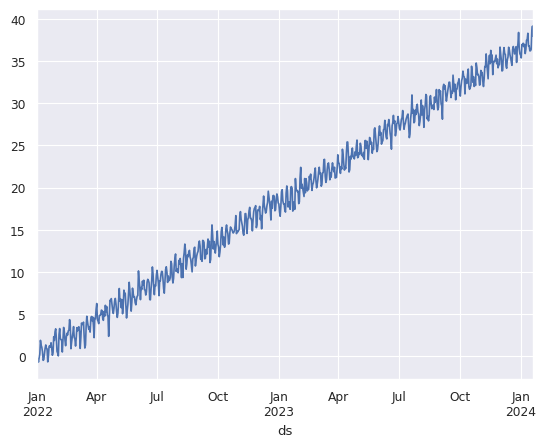

In [3]:
df.set_index('ds').y.plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          750 non-null    datetime64[ns]
 1   y           750 non-null    float64       
 2   regressor1  750 non-null    float64       
 3   regressor2  750 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 29.3 KB


In [5]:
intervention = ['2024-01-06', '2024-01-16']

In [17]:
pre_check = sensitivity(
    df=df,
    test_period=['2023-12-25', '2024-01-05'],
    cross_validation_steps=10,
    alpha=0.05,
    model_params={'changepoint_range': [0.85,0.50],
                  'changepoint_prior_scale': [0.05, 0.50]},
    regressors=['regressor2', 'regressor1'],
    verbose=True,
    autocorrelation = True,
    n_samples=1000)

pre_check.run(prio = True)

Training period: 2022-01-01 00:00:00 to 2023-12-24
Test period: 2023-12-25 to 2024-01-05

Post period: 2024-01-06 to 2024-01-20 00:00:00

Prediction horizon: 12 days
Grid Search Cross-Validation mode:

Total parameters combinations: 4
{'changepoint_range': 0.5, 'changepoint_prior_scale': 0.05}


100%|██████████| 136/136 [00:19<00:00,  7.12it/s]



Cross-validation MAPE: 6.09%

Seasons detected: ['weekly']
+----+-------------+------------------+----------+---------------+------------+---------------+
|    | Regressor   | Regressor Mode   |   Center |   Coef. Lower |       Coef |   Coef. Upper |
+====+=============+==================+==========+===============+============+===============+
|  0 | regressor2  | additive         |  8.64278 |    -0.0351603 | -0.0351603 |    -0.0351603 |
+----+-------------+------------------+----------+---------------+------------+---------------+
|  1 | regressor1  | additive         |  8.64782 |    -0.0259532 | -0.0259532 |    -0.0259532 |
+----+-------------+------------------+----------+---------------+------------+---------------+
|  2 | y_lag7      | additive         | 17.9134  |     0.0250555 |  0.0250555 |     0.0250555 |
+----+-------------+------------------+----------+---------------+------------+---------------+
|  3 | y_lag14     | additive         | 17.5649  |     0.0392136 |  0.039213

In [18]:
mde = pre_check.data_analysis()
mde.head(5)

,model,pvalue,train,test,ci_lower,ci_upper,ci_mean,y_pred_period,y_test_period,y_pred_period_mean,y_test_period_mean,y_last90days_mean,y_historical_mean
injected_effect,,,,,,,,,,,,,
0.10,"{'changepoint_range': 0.5, 'changepoint_prior_...",0.0,"[[r2, 0.9961902493005437], [MAE, 0.51358811134...","[[r2, 0.48871096312863427], [MAE, 0.5411964595...",422.370182,455.026777,"[36.05918241552117, 37.2377264767416]",438.567373,43.776149,36.547281,3.648012,34.041585,18.266077
0.14,"{'changepoint_range': 0.5, 'changepoint_prior_...",0.0,"[[r2, 0.9961902493005437], [MAE, 0.51358811134...","[[r2, 0.48871096312863427], [MAE, 0.5411964595...",422.370182,455.026777,"[35.991018084618155, 37.18249054570438]",438.567373,60.750575,36.547281,5.062548,34.041585,18.266077
0.18,"{'changepoint_range': 0.5, 'changepoint_prior_...",0.0,"[[r2, 0.9961902493005437], [MAE, 0.51358811134...","[[r2, 0.48871096312863427], [MAE, 0.5411964595...",422.370182,455.026777,"[36.0004737402641, 37.19905224472805]",438.567373,77.725000,36.547281,6.477083,34.041585,18.266077
0.22,"{'changepoint_range': 0.5, 'changepoint_prior_...",0.0,"[[r2, 0.9961902493005437], [MAE, 0.51358811134...","[[r2, 0.48871096312863427], [MAE, 0.5411964595...",422.370182,455.026777,"[36.006355856960006, 37.22517340286517]",438.567373,94.699425,36.547281,7.891619,34.041585,18.266077
0.26,"{'changepoint_range': 0.5, 'changepoint_prior_...",0.0,"[[r2, 0.9961902493005437], [MAE, 0.51358811134...","[[r2, 0.48871096312863427], [MAE, 0.5411964595...",422.370182,455.026777,"[36.009891636773766, 37.24569646676102]",438.567373,111.673851,36.547281,9.306154,34.041585,18.266077


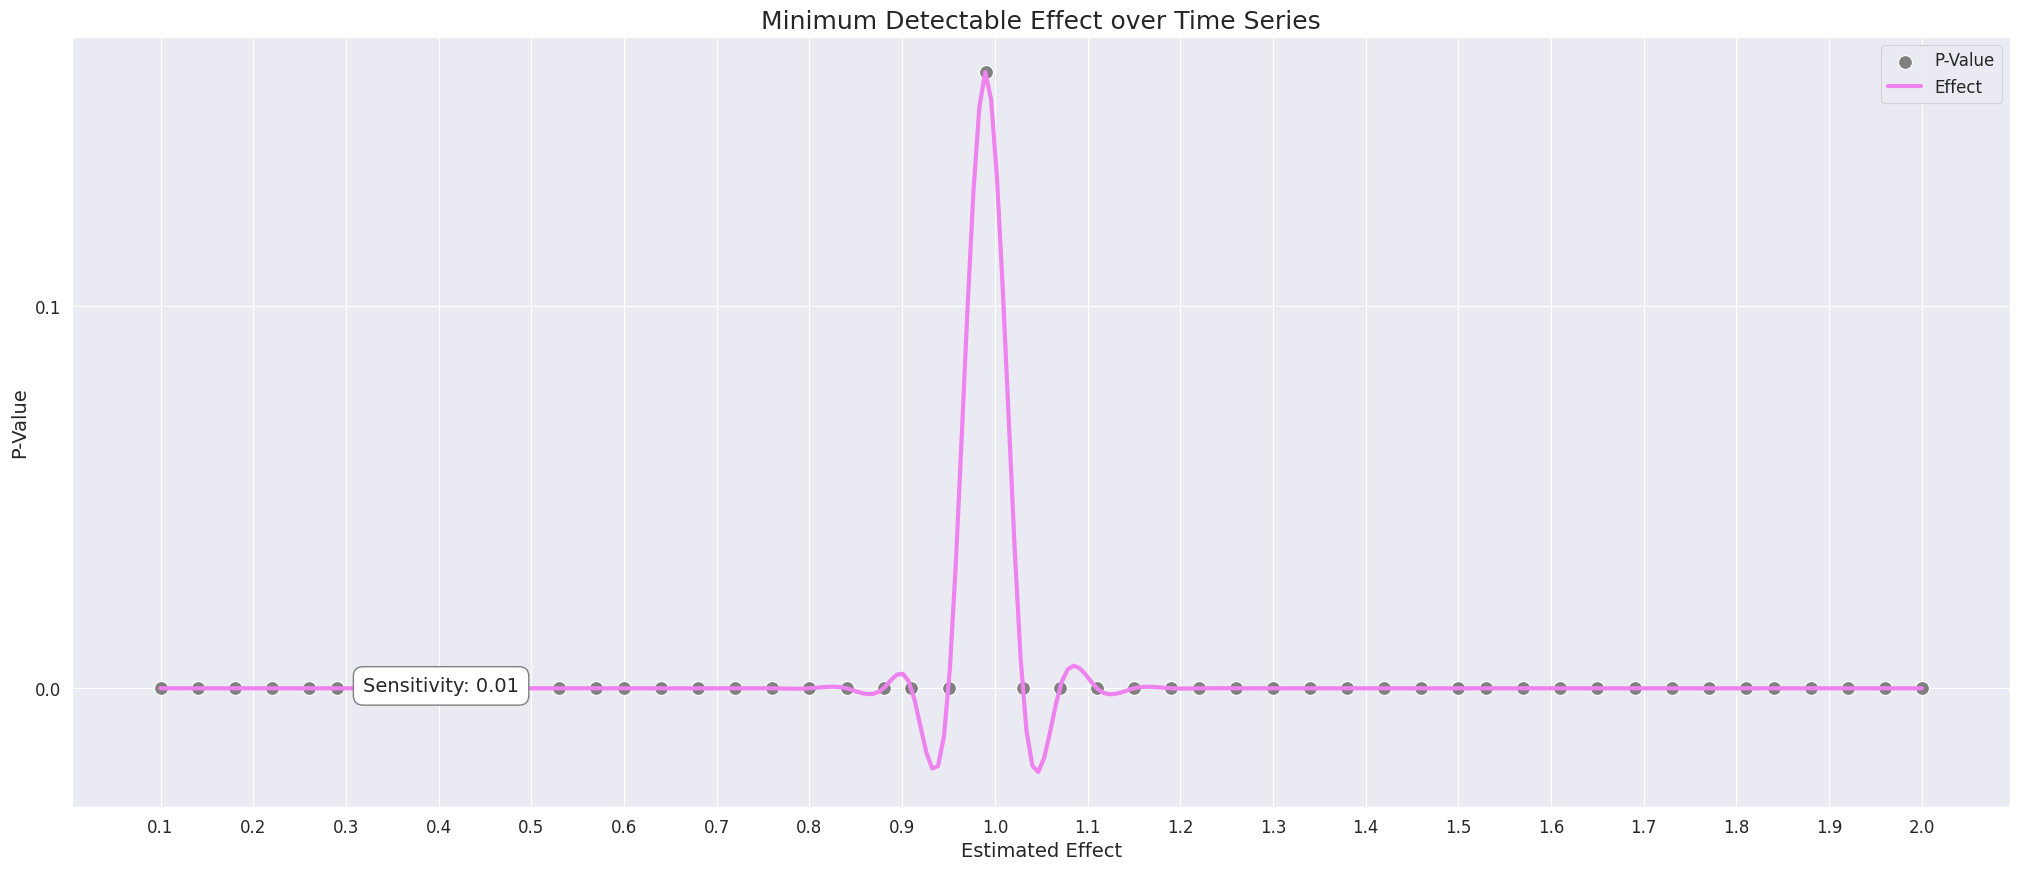

In [19]:
pre_check.plot()

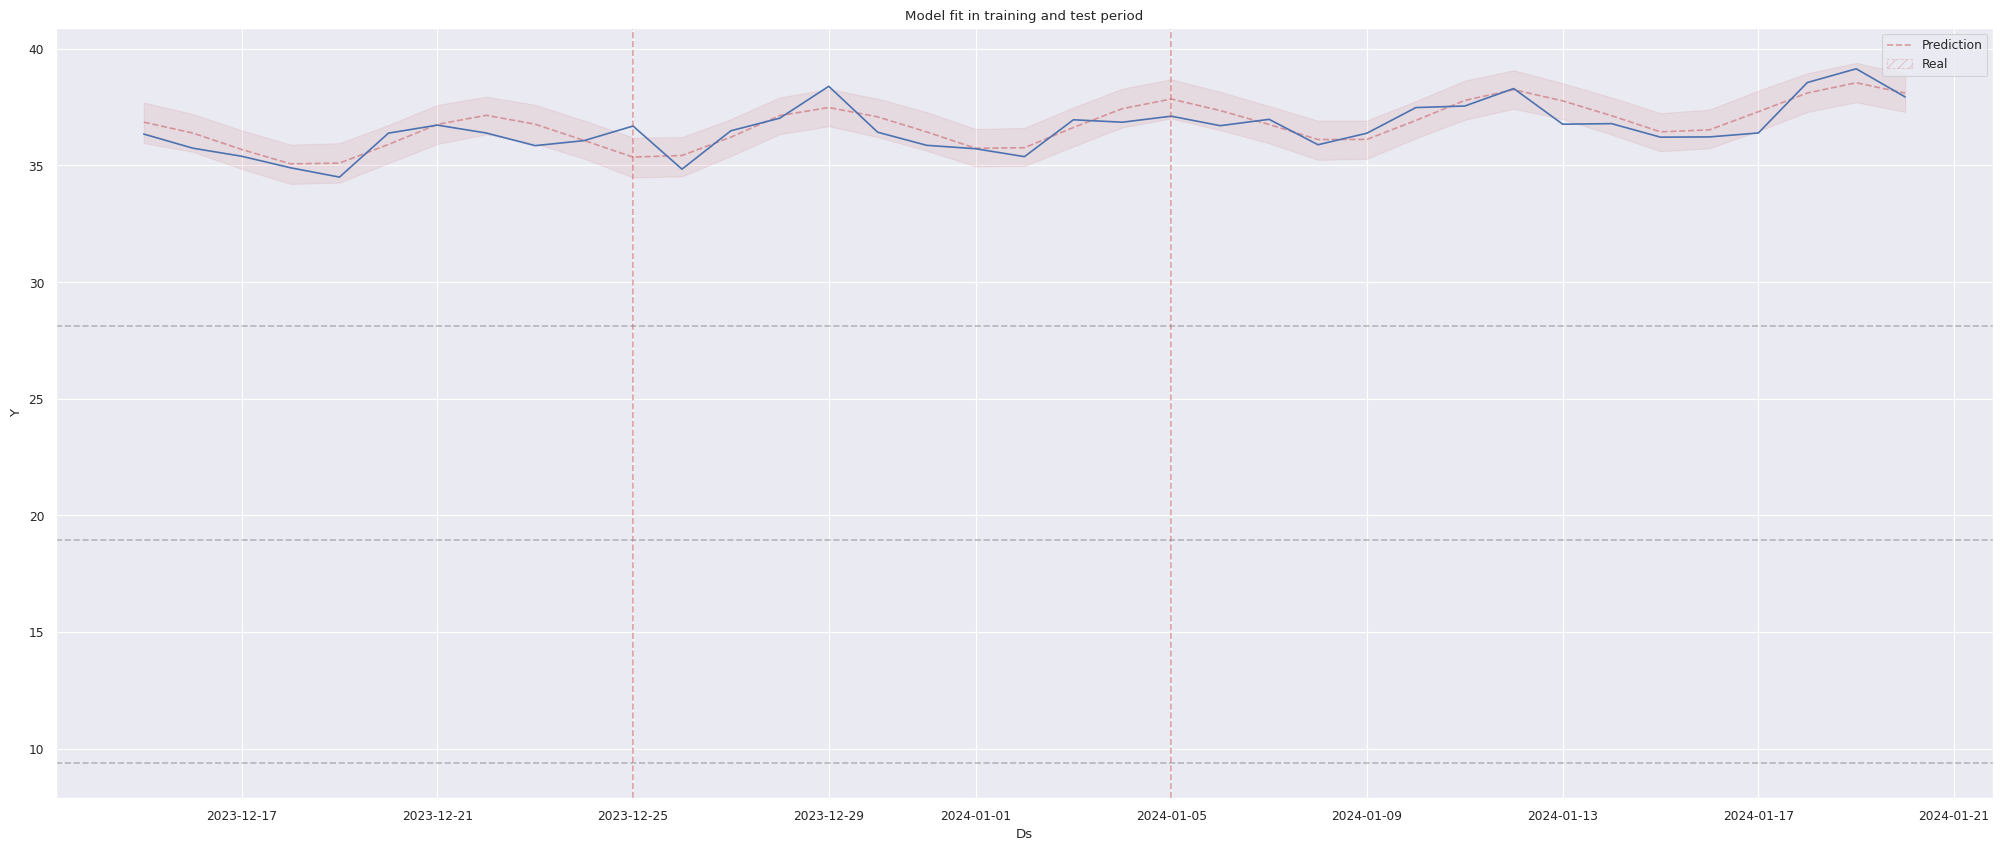

In [20]:
pre_check.plot(method = 'training')

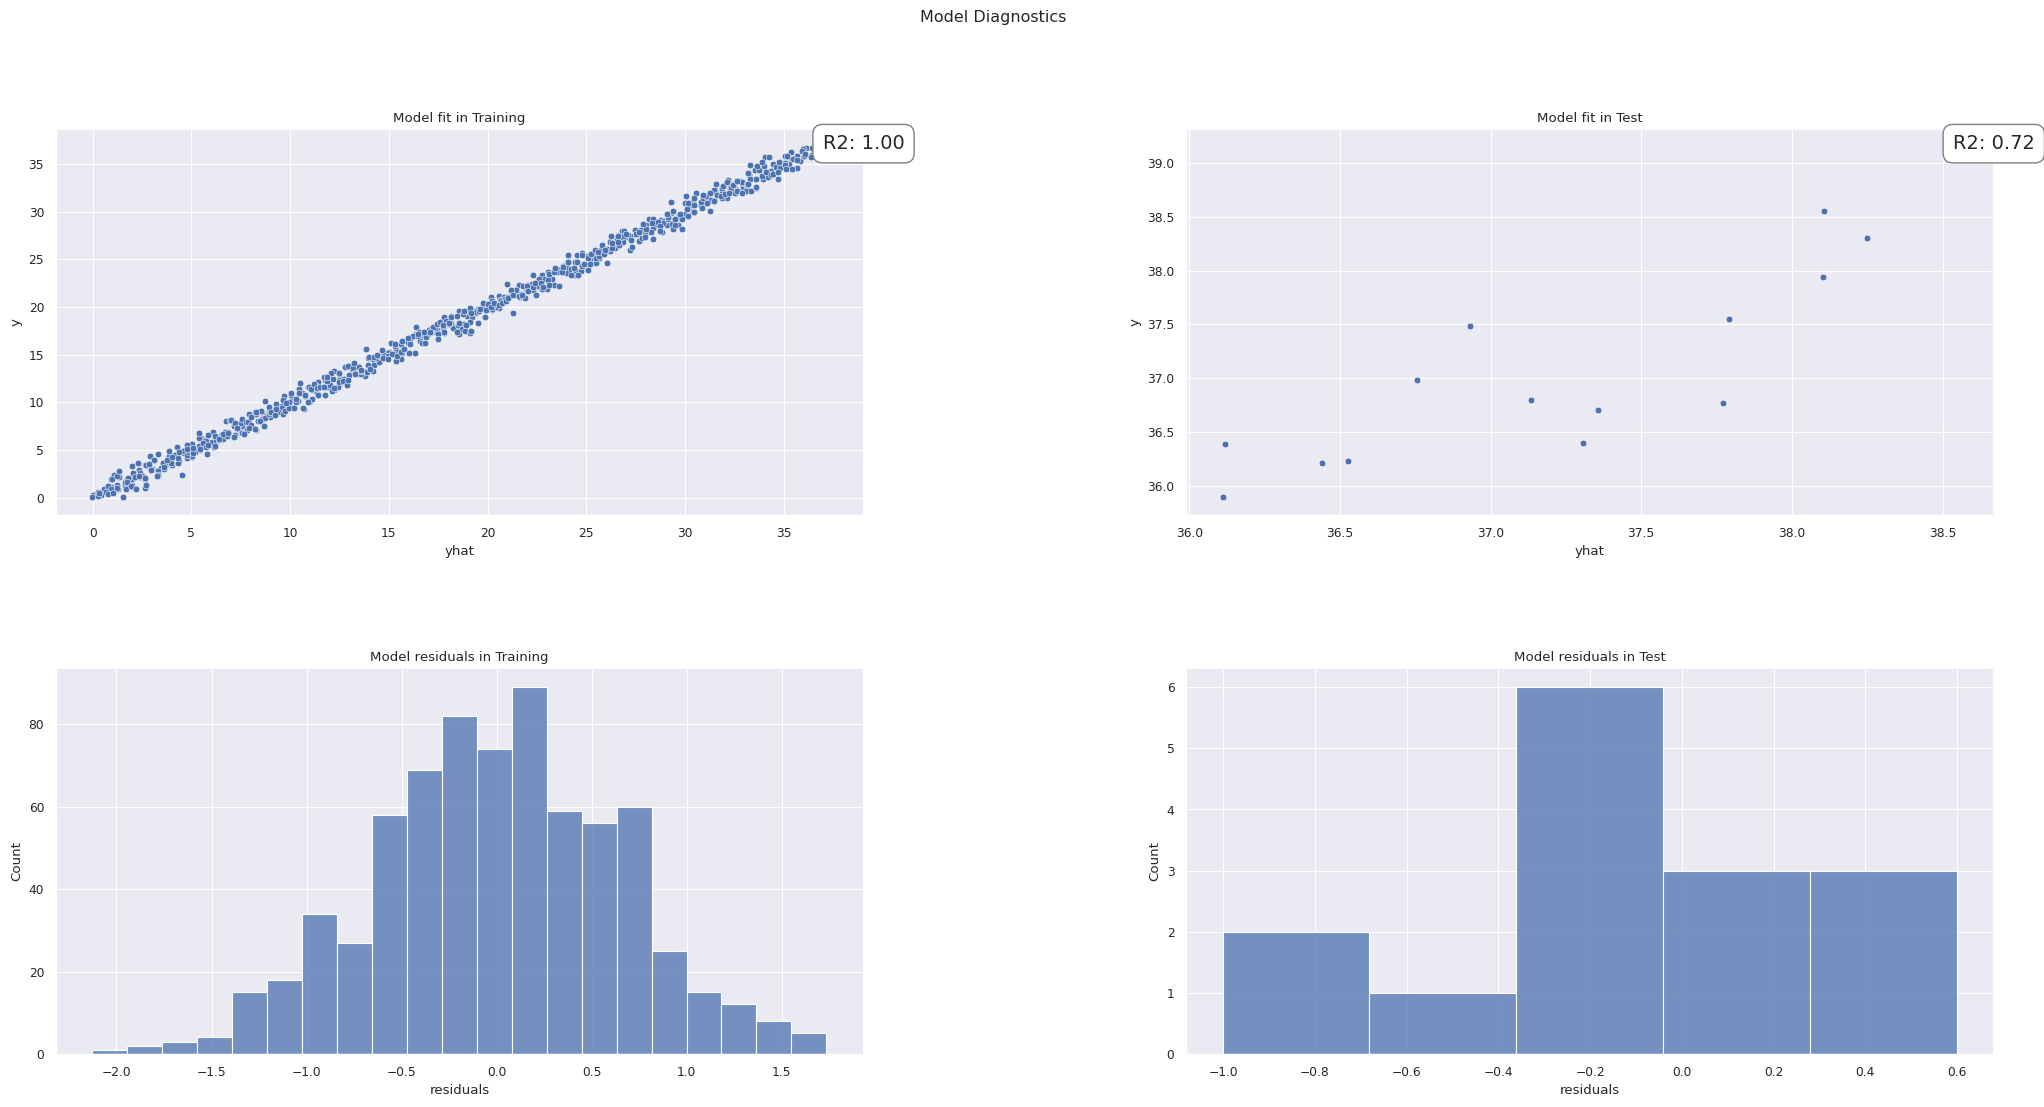

In [21]:
pre_check.plot(method = 'diagnostic', figsize = (25,12))

In [22]:
pre_check.model_best_parameters()

{'changepoint_range': 0.5, 'changepoint_prior_scale': 0.05}

In [23]:
data = tscausalinference(data = df, intervention = intervention, cross_validation_steps=15, 
                         model_params = {'changepoint_range': 0.5, 'changepoint_prior_scale': 0.05, 'yearly_seasonality':True, 
                                         'weekly_seasonality':True}, 
                         n_samples=5000, 
                         model_type='gam')

In [24]:
data.run(prio = True)

Training period: 2022-01-01 00:00:00 to 2024-01-05
Test period: 2024-01-06 to 2024-01-16

Post period: 2024-01-17 to 2024-01-20 00:00:00

Prediction horizon: 11 days
Custom parameters grid: 
{'changepoint_range': 0.5, 'changepoint_prior_scale': 0.05, 'yearly_seasonality': True, 'weekly_seasonality': True, 'interval_width': 0.95}


100%|██████████| 47/47 [00:07<00:00,  6.59it/s]



Cross-validation MAPE: 2.15%

Seasons detected: ['yearly', 'weekly']
+------------------------+
 Pre intervention metrics
+------------------------+
| Metric      |     Value |
|:------------|----------:|
| r2          |  0.996501 |
| MAE         |  0.501856 |
| MAPE (%)    | 11.6376   |
| Noise (Std) |  0.626892 |


In [25]:
data.summarization(method = 'detailed')

+-----------------------+------------+
 / / / / intervention metrics / / / /
+-----------------------+------------+
| Metric                |     Value |
|:----------------------|----------:|
| Actual cumulative     | 405.292   |
| Predicted cumulative: | 401.4     |
| Difference            |   3.89201 |
| Change (%)            |   0.96961 |
+-----------------------+------------+
    CI 95%: [388.0, 415.0]


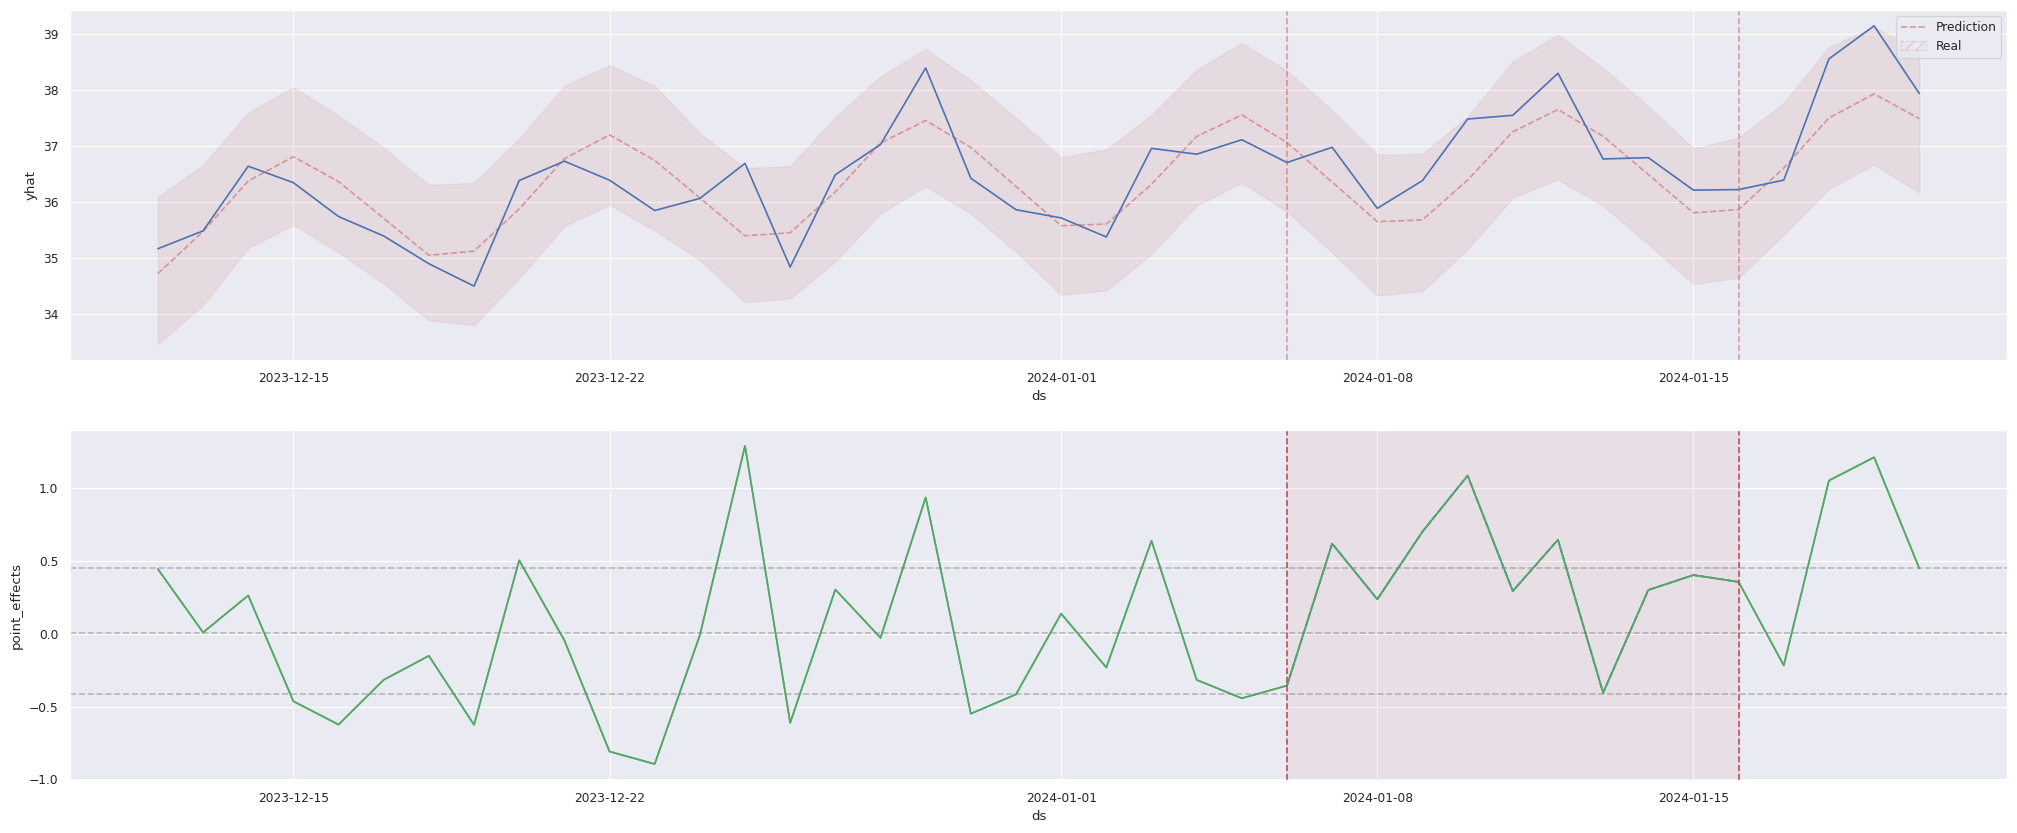

In [26]:
data.plot()

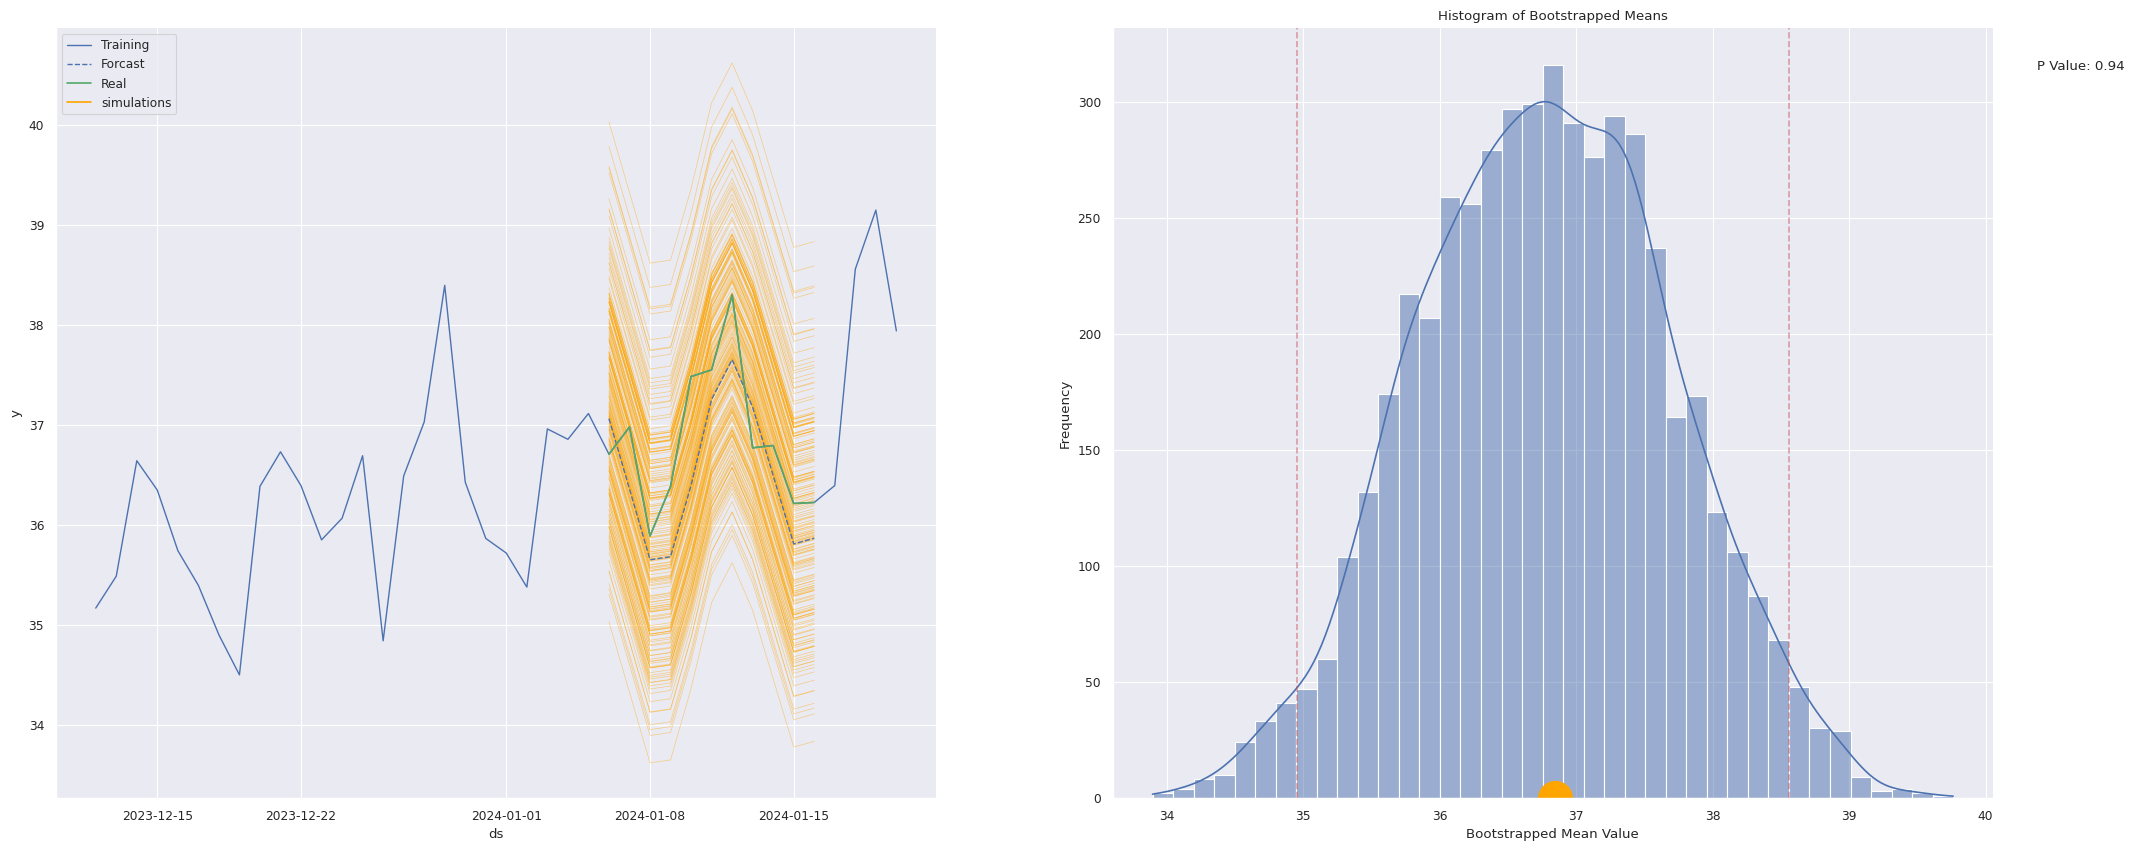

In [27]:
data.plot(method='simulations',simulation_number = 200)

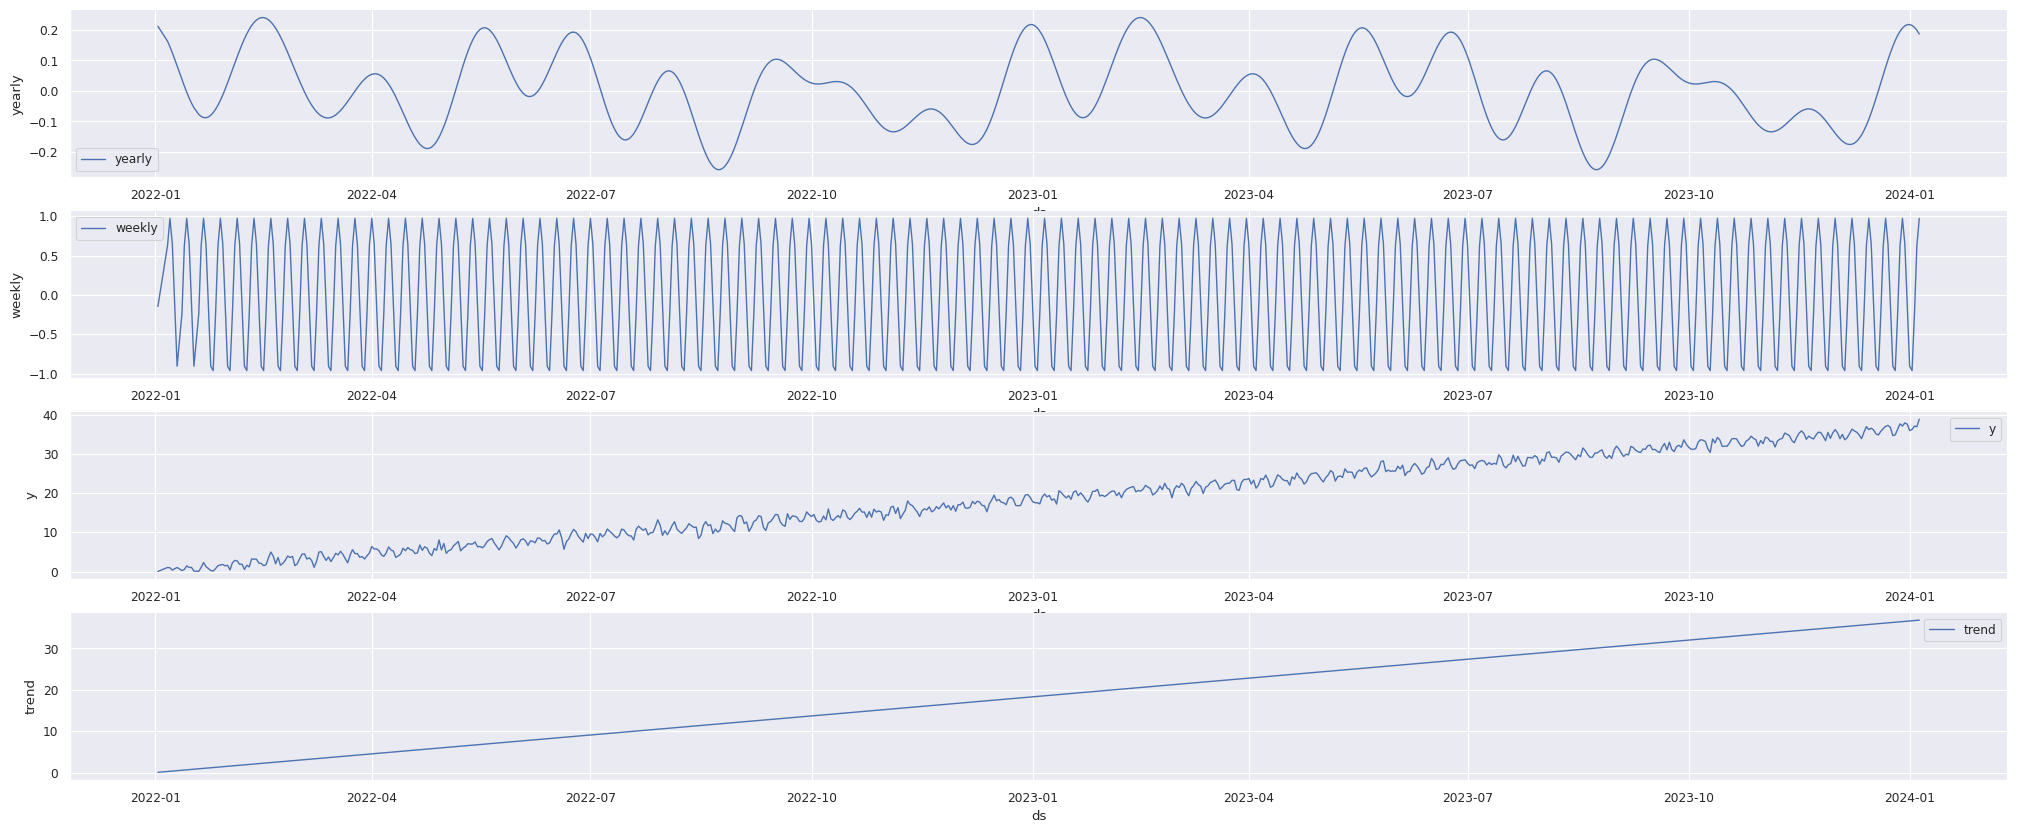

In [17]:
data.plot('decomposition')